# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Building a Student Intervention System

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?*

**Answer: ** It is a binary classification problem. 

The goal of the project is to assign a label to each student indicating whether they pass or not. We are concerned only with their group membership not any distribution of their results over continuous range of possible values -- in which case we would need to concieve of the task as a regression problem.

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [59]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score

# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"



Student data read successfully!


### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


In [60]:
# TODO: Calculate number of students
n_students = len(student_data)

# TODO: Calculate number of features
n_features = len(student_data.columns[:-1])

# TODO: Calculate passing students
n_passed = sum(student_data['passed'] == 'yes')

# TODO: Calculate failing students
n_failed = sum(student_data['passed'] == 'no')

# TODO: Calculate graduation rate
grad_rate = 100.*n_passed/n_students

# Print the results
print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of features: 30
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%


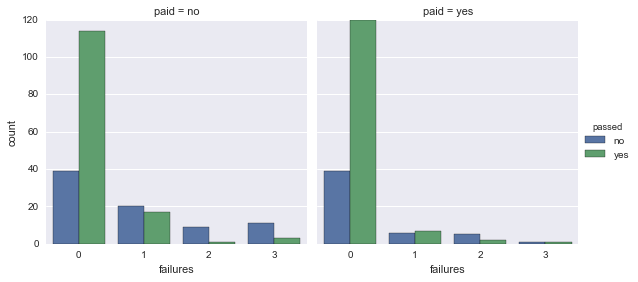

In [61]:
# Graphical exploration of the dataset
%matplotlib inline
import seaborn as sns
sns.factorplot("failures", col="paid", data=student_data, hue="passed", kind="count")

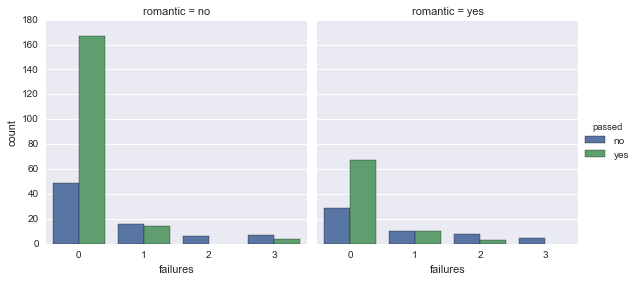

In [62]:
sns.factorplot("failures", col="romantic", data=student_data, hue="passed", kind="count")

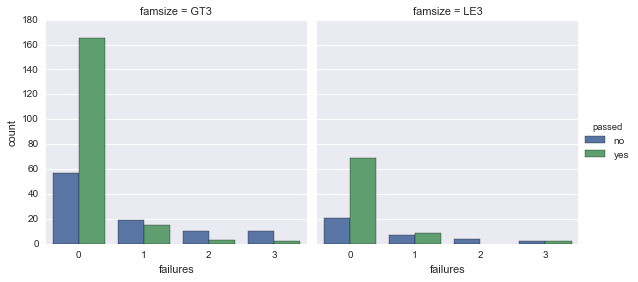

In [63]:
sns.factorplot("failures", col="famsize", data=student_data, hue="passed", kind="count")

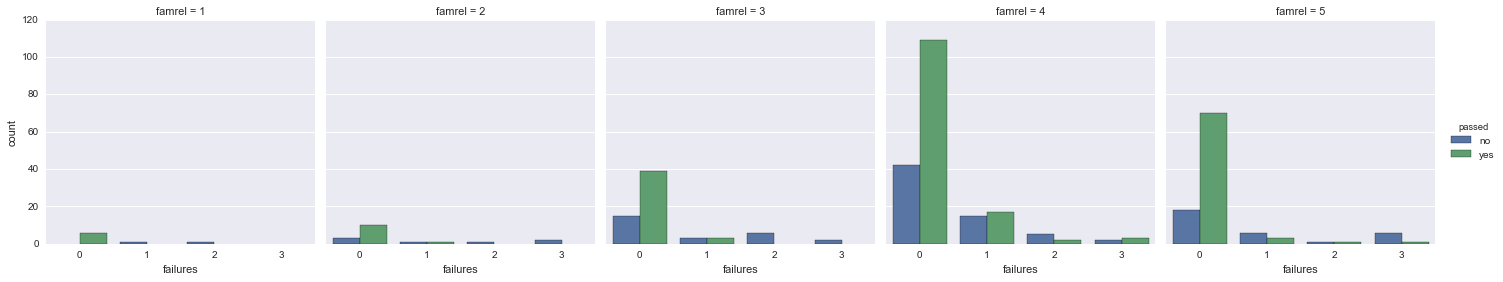

In [64]:
sns.factorplot("failures", col="famrel", data=student_data, hue="passed", kind="count")

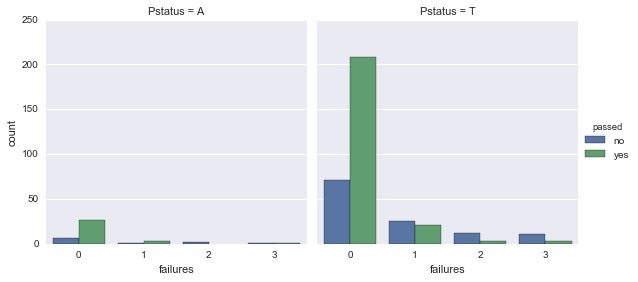

In [65]:
sns.factorplot("failures", col="Pstatus", data=student_data, hue="passed", kind="count")

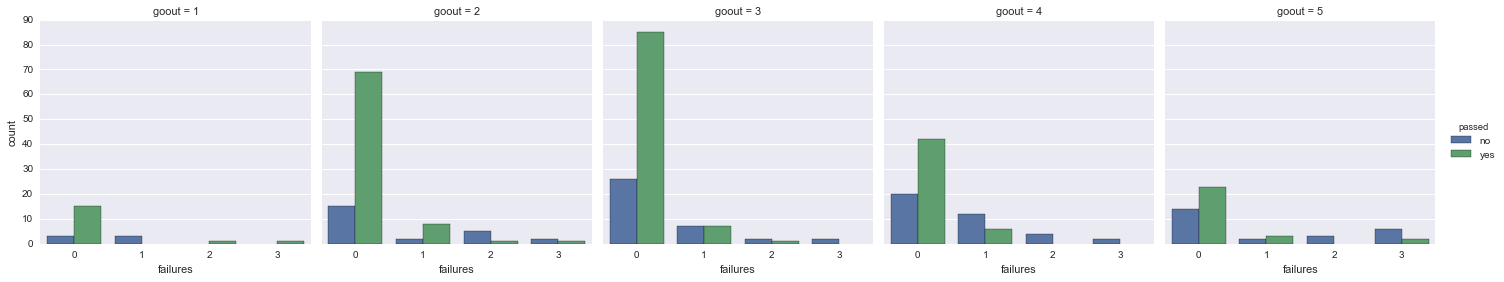

In [66]:
sns.factorplot("failures", col="goout", data=student_data, hue="passed", kind="count")

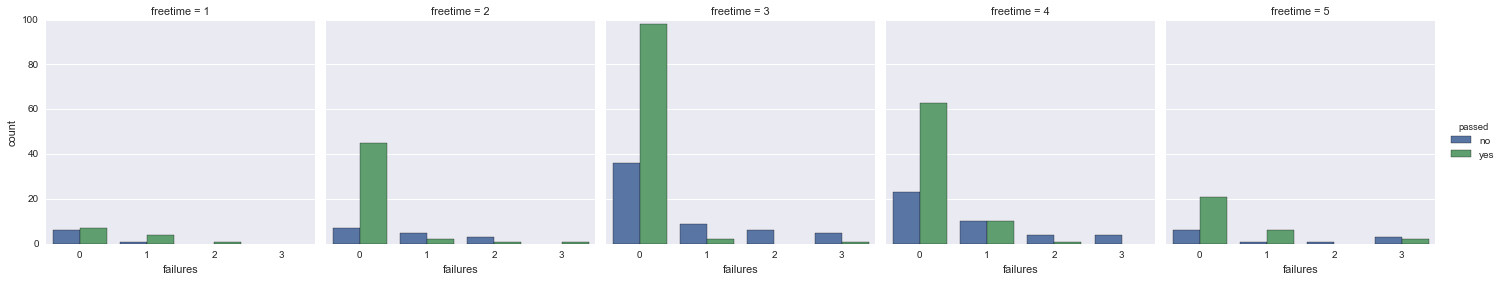

In [67]:
sns.factorplot("failures", col="freetime", data=student_data, hue="passed", kind="count")

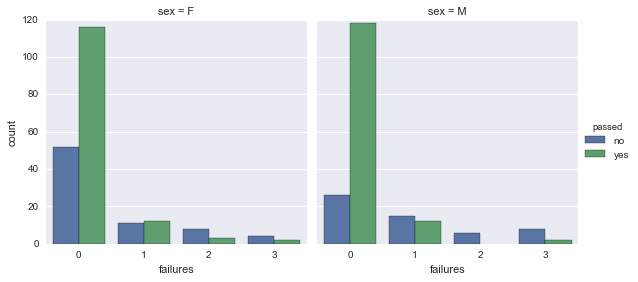

In [68]:
sns.factorplot("failures", col="sex", data=student_data, hue="passed", kind="count")

After exploring briefly the dataset it seems there is indeed no simple rule that could explain why and when students decide not to pursue the graduation (except for when students go out really often -- that seems to correlate with increased drop out rate). Using machine learning to capture complexity of the problem seems to be a good idea ... 

## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

In [69]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [70]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

# Here I have decided to run preprocessing on all, including the target, columns
sd = preprocess_features(student_data)

print "Processed feature columns ({} total features):\n{}".format(len(sd.columns), list(sd.columns))
features_cols = list(sd.columns[:-1])
print 'features_cols', features_cols
target_col = list(sd.columns[-1:])

X_all = sd[features_cols]
y_all = sd[target_col]

print X_all.head()
print y_all.head()

Processed feature columns (49 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'passed']
features_cols ['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teac

### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [71]:
# TODO: Import any additional functionality you may need here
from sklearn.cross_validation import train_test_split
# initializing variable "random_state" that we will use 
# wherever appropriate to allow for reproducibility of
# the results obtained below  
random_state = 30

# TODO: Set the number of training points
num_train = 300

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# TODO: Shuffle and split the dataset into the number of training and testing points above
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=random_state)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape)
print "Testing set has {} samples.".format(X_test.shape)

Training set has (300, 48) samples.
Testing set has (95, 48) samples.


## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. For each model chosen*
- Describe one real-world application in industry where the model can be applied. *(You may need to do a small bit of research for this — give references!)* 
- What are the strengths of the model; when does it perform well? 
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answer: ** 
- **Support Vector Machine Classifier (SVM)**
  The SVM algorithm explicitely considers the margin maximization, it does not only look for the best separation between different classes, it looks for boundaries with the largest margins as well. The algorithm works well in high dimensional spaces. 
  The disadvantage maybe that the training time for SVMs grows as a cube of the number of training examples, which may make them usuitable for very large datasets, but this is not at all the case in this problem.
  Example of on of early successful applications of the SVM classification in the domaine of computer vision is the face recognition problem as described in [Labeled Faces in the Wild](http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html).


- **K-Nearest Neighbors Classifier (KNN)**
  KNN is an non-parametric, instance based learning algorithm. It looks for a predefined number of training points closest to the new point and predicts the label for the new sample based on values of those. 
  The distance definition can incorporate the domain knowledge and may significantly affect the performance of the algorithm. Given the sufficient amount of examples it can perform very well. 
  It is often successful in classification situations where the decision boundary is very irregular [[scikit documentation](http://scikit-learn.org/stable/modules/neighbors.html)].
  The limitation of KNNs is that they may require prohibitively large memory for very complex tasks -- since the basic implementation fo the algorithm learns in only very limited sense -- it remembers all of the training instances. 
  The prediction step may be also slower compared to alternative algorithms, as the prediction involves search through the remembered instances.
  KNN classification algorithm is widely used, even though it can rarely compete in accuracy with SVMs or CNNs, it is easy to understand and may be still useful. One practical example is handwritten digit recognition as presented in [Handwritten Digit Recognition Using K Nearest-Neighbor, Radial-Basis Function, and Backpropagation Neural Networks]( http://www.mitpressjournals.org/doi/abs/10.1162/neco.1991.3.3.440#.WOAgbRLyiEI).



- **Decision Tree Classifier (DT)**
  DT are a non-parametric supervised learning method. It learns a set of rules inferred from the data features. Advantages of DTs are that they are easy to understand, visualize and interpret. The cost of prediction is logarithmic in the number of data points used to train the tree.
  The disadvantages of DTs is that they are prone to overfitting. They do not work well for skewed classes and some problems may be particularly hard to capture using DTs (XOR, parity or multiplexer problems) [[scikit documentation](http://scikit-learn.org/stable/modules/tree.html)].
  Practical example of the Decision Tree based classification is recognizing three dimensional objects as presented in [Realtime Object Recognition Using Decision Tree Learning](http://www.informatik.uni-bremen.de/kogrob/papers/rc05-objectrecognition.pdf).




### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [72]:
from sklearn.metrics import classification_report, confusion_matrix
# I have modified the three helper functions so that they return, not only print, the scores and timing information 
# this will allow me to generate the summary table in an automated way further down
# In train_predict function I have included also generation of classification_report and confussion_matrix
# to gain further insights into the performance of tested models

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    train_time = end - start
    print "Trained model in {:.4f} seconds".format(train_time)

    return train_time
    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    predict_time = end - start
    print "Made predictions in {:.4f} seconds.".format(predict_time)
    return f1_score(target.values, y_pred, pos_label=1), predict_time


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_time = train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    f1_train, predict_time_train = predict_labels(clf, X_train, y_train)
    print "F1 score for training set: {:.4f}.".format(f1_train)
    f1_test, predict_time_test = predict_labels(clf, X_test, y_test)
    print "Train confusion matrix"
    print confusion_matrix(clf.predict(X_train), y_train)
    print "Train classification report"
    print classification_report(clf.predict(X_train), y_train)
    print "F1 score for test set: {:.4f}.".format(f1_test)
    print "Test confusion matrix"
    print confusion_matrix(clf.predict(X_test), y_test)
    print "Test classification report"
    print classification_report(clf.predict(X_test), y_test)
    return f1_train, predict_time_train, f1_test, predict_time_test, train_time

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.

In [73]:
# TODO: Import the three supervised learning models from sklearn
import warnings
warnings.simplefilter("ignore")

# Normalizing the features
from sklearn.preprocessing import normalize
X_train = normalize(X_train)
X_test = normalize(X_test)

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# TODO: Initialize the three models
clf_A = SVC(random_state=random_state)
clf_B = KNeighborsClassifier()
clf_C = DecisionTreeClassifier(random_state=random_state)
#clf_D = AdaBoostClassifier()
#clf_E = GaussianNB()
#clf_F = RandomForestClassifier()
#clf_G = BaggingClassifier(random_state=random_state)
#clf_H = SGDClassifier()
#clf_I = PassiveAggressiveClassifier()
#clf_J = LogisticRegression()
#clf_K = LinearSVC()

# TODO: Set up the training set sizes
# -- will do that within the loop below
#X_train_100 = X_train[:100]
#y_train_100 = y_train[:100]

#X_train_200 = X_train[:200]
#y_train_200 = y_train[:200]

#X_train_300 = X_train[:300]
#y_train_300 = y_train[:300]

# TODO: Execute the 'train_predict' function for each classifier and each training set size
# train_predict(clf, X_train, y_train, X_test, y_test)
results = []
table_template = '''
** Classifer {clf_order:d} - {clf_name}**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |  {train_time_100:.4f}   | {predict_time_100:.4f} |{f1_train_100:.4f}|{f1_test_100:.4f}|
| 200               |  {train_time_200:.4f}   | {predict_time_200:.4f} |{f1_train_200:.4f}|{f1_test_200:.4f}|
| 300               |  {train_time_300:.4f}   | {predict_time_300:.4f} |{f1_train_300:.4f}|{f1_test_300:.4f}|
'''
output_table = ''
#y_test = np.array(y_test).reshape((len(y_test),))
for k, clf in enumerate([clf_A, clf_B, clf_C]): #, clf_D, clf_E, clf_F, clf_G, clf_H, clf_I, clf_J]):
    clf_name = clf.__class__.__name__
    to_format = {'clf_order': k+1, 'clf_name': clf_name}
    for n in [100, 200, 300]:
        f1_train, predict_time_train, f1_test, predict_time_test, train_time =\
        train_predict(clf, X_train[:n], y_train[:n], X_test, y_test)
        to_format['train_time_%d' % n] = train_time
        to_format['predict_time_%d' % n] = predict_time_test
        to_format['f1_train_%d' % n] = f1_train
        to_format['f1_test_%d' % n] = f1_test
    output_table += table_template.format(**to_format) + 3*'\n'
    results.append(to_format)
print output_table

Training a SVC using a training set size of 100. . .
Trained model in 0.0019 seconds
Made predictions in 0.0013 seconds.
F1 score for training set: 0.8095.
Made predictions in 0.0011 seconds.
Train confusion matrix
[[ 0  0]
 [32 68]]
Train classification report
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.68      0.81       100

avg / total       1.00      0.68      0.81       100

F1 score for test set: 0.7975.
Test confusion matrix
[[ 0  0]
 [32 63]]
Test classification report
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.66      0.80        95

avg / total       1.00      0.66      0.80        95

Training a SVC using a training set size of 200. . .
Trained model in 0.0053 seconds
Made predictions in 0.0040 seconds.
F1 score for training set: 0.8166.
Made predictions in 0.0019 seconds.
Train confusion m

### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

In [74]:
# helper code for including consistent numbers in the answer for Question #3
training_times = np.array([item['train_time_300']*1e3 for item in results])
predict_times = np.array([item['predict_time_300']*1e3 for item in results])
r = (results[0]['train_time_300']*1e3, results[0]['predict_time_300']*1e3, results[0]['f1_test_300'],\
     results[1]['train_time_300']*1e3, results[1]['predict_time_300']*1e3, results[1]['f1_test_300'],\
     results[2]['train_time_300']*1e3, results[2]['predict_time_300']*1e3, results[2]['f1_test_300'],\
     training_times.min(), training_times.max(), training_times.max()/training_times.min(),\
     predict_times.min(), predict_times.max(), predict_times.max()/predict_times.min())

a = discussion = '''Of the three selected models, the SupportVectorClassifier (SVC) performed the best as judged by the f1_score on the test set. The second best model was KNeighborsClassifier. The DecisionTreeClassifier with the default parameters typically did not perform well on the test data due to the probable overfit (data not shown).

The training time for the SVC with 300 train examples was %.1f ms with the prediction time of %.1f ms, with the f1_score on the training set of %.4f. The KNeighborsClassifier took %.1f ms to train and %.1f ms to predict with the test f1_score of %.4f. The DecisionTreeClassifier took %.1f ms to train and %.1f ms to predict with the test f1_score of %.4f. 

The training times of all of the three best models vary between %.1f and %.1f ms (factor of approximately %d), while prediction time varies between %.1f ms and %.1f ms (factor of %d). The training and prediction times for the three models are low in absolute terms and based on the overall accuracy we recommend the SupportVectorClassifier for further optimization.''' % r 


** Classifer 1 - SVC**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |  0.0020   | 0.0011 |0.8095|0.7975|
| 200               |  0.0054   | 0.0019 |0.8166|0.7975|
| 300               |  0.0112   | 0.0028 |0.8048|0.7975|




** Classifer 2 - KNeighborsClassifier**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |  0.0006   | 0.0018 |0.8219|0.7188|
| 200               |  0.0007   | 0.0029 |0.8552|0.7519|
| 300               |  0.0009   | 0.0042 |0.8525|0.7634|




** Classifer 3 - DecisionTreeClassifier**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |  0.0019   | 0.0001 |1.0000|0.6555|
| 200               |  0.0041   | 0.0001 |1.0000|0.7200|
| 300               |  0.0065   | 0.0001 |1.0000|0.6777|












## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Choosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

**Answer: ** Of the three selected models, the SupportVectorClassifier (SVC) performed the best as judged by the f1_score on the test set. The second best model was KNeighborsClassifier. The DecisionTreeClassifier with the default parameters typically did not perform well on the test data due to the probable overfit (data not shown).

The training time for the SVC with 300 train examples was 11.2 ms with the prediction time of 2.8 ms, with the f1_score on the training set of 0.7975. The KNeighborsClassifier took 0.9 ms to train and 4.2 ms to predict with the test f1_score of 0.7634. The DecisionTreeClassifier took 6.5 ms to train and 0.1 ms to predict with the test f1_score of 0.6777. 

The training times of all of the three best models vary between 0.9 and 11.2 ms (factor of approximately 12), while prediction time varies between 0.1 ms and 4.2 ms (factor of 41). The training and prediction times for the three models are low in absolute terms and based on the overall accuracy we recommend the SupportVectorClassifier for further optimization.

### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** Of the models tested, the support vector machine (SVM) classifier performs the best. 

The SVM works by taking the records of previous students (family size, gender, extra curicular activities ...) and uses them to determine a boundary between the students that graduated successfully and those who did not. The boundary that the SVM finds maximizes the margin between the two classes of student in the hyperspace spanned by the features available in the dataset.

(-5.5046313588827136,
 5.5972585365369838,
 -7.3058247094175783,
 8.1623394561374987)

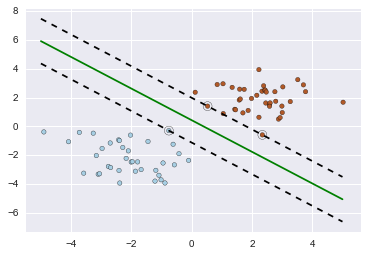

In [75]:
# based on sckit tutorial 
# http://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html
import matplotlib.pyplot as plt
# we create 77 separable points
np.random.seed(random_state)
X = np.r_[np.random.randn(37, 2) - [2, 2], np.random.randn(40, 2) + [2, 2]]
Y = [0] * 37 + [1] * 40

# fit the model
clf = SVC(kernel='linear', random_state=random_state)
clf.fit(X, Y)

# get the separating hyperplane
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 5)
yy = a * xx - (clf.intercept_[0]) / w[1]

# plot the parallels to the separating hyperplane that pass through the
# support vectors
b = clf.support_vectors_[0]
yy_down = a * xx + (b[1] - a * b[0])
b = clf.support_vectors_[-1]
yy_up = a * xx + (b[1] - a * b[0])

# plot the line, the points, and the nearest vectors to the plane
plt.plot(xx, yy, 'g-')
plt.plot(xx, yy_down, 'k--')
plt.plot(xx, yy_up, 'k--')

plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=80, facecolors='none')
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)

plt.axis('tight')

For instance in the example in the picture above, there is an infinite number of lines separating the blue and red circles, the SVM will specifically select the separating line (the green line) with maximum distance to examples of either class. This renders the decision boundary more robust with respect to noise and mistakes on either side.

It is often impossible to draw a linear or (hyper-) planar boundary in a low dimensional spaces. When stuck, [switch to another perspective](https://youtu.be/_PwhiWxHK8o?t=2485). To allow the separation in those cases the SVM uses a kernel function, $\Phi$, which projects low dimensional input features into higher dimensional space in which the separation becomes possible. 

Using the learned boundary, the SVM can look at a new student's data and predict whether the student will pass or not.

In the example below we consider randomly generated data points not separable in two dimensions that become separable using transformation [x, y] -> [x2, y2, x2+y2].

Percentage of '0' labels: 0.5
Percentage of '1' labels: 0.5


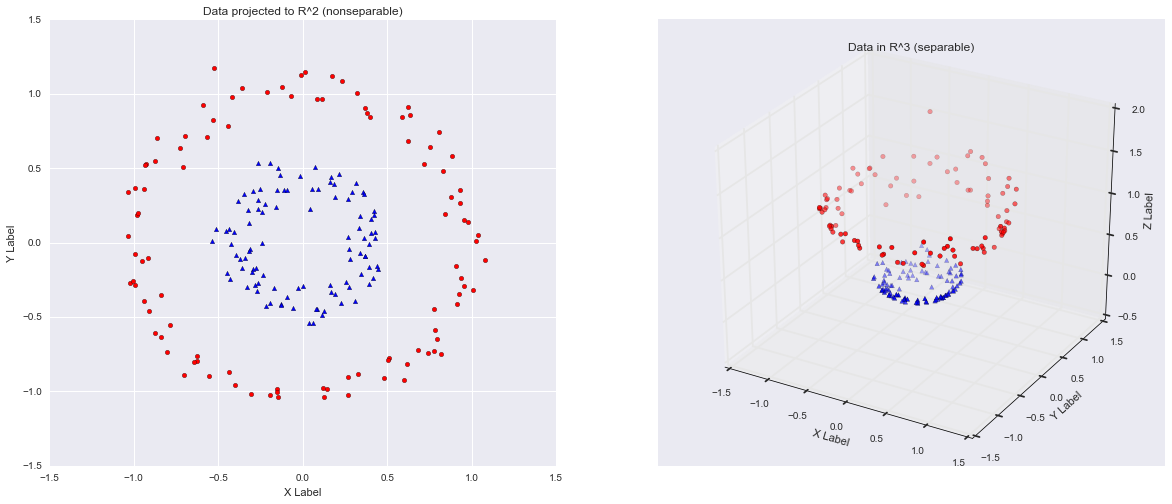

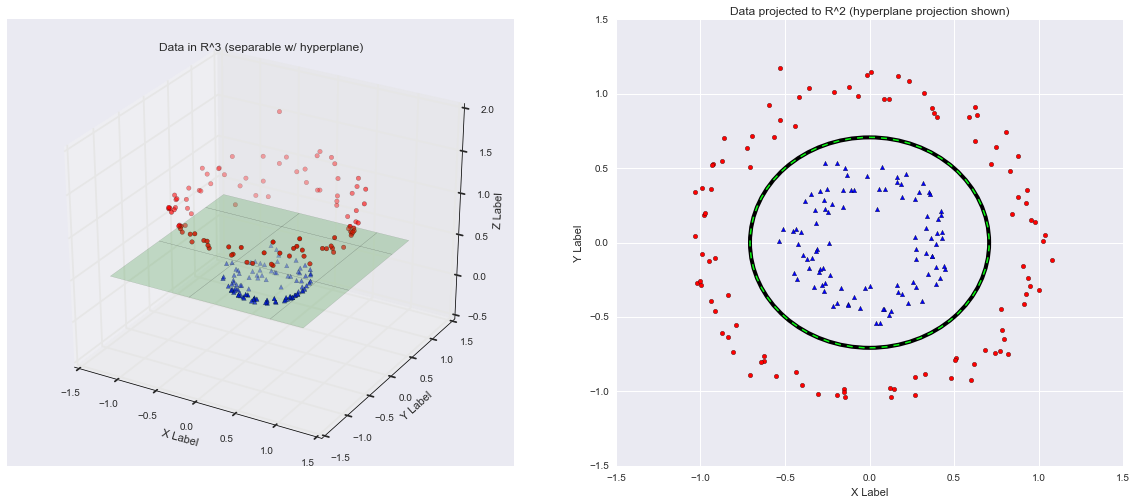

In [76]:
# This example is based on the tutorial by Eric Kim
# http://www.eric-kim.net/eric-kim-net/posts/1/kernel_trick.html
from math import sqrt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import pylab as pl

def randrange(n, vmin, vmax):
    return (vmax-vmin)*np.random.rand(n) + vmin

def fn_kernel(x1, x2):
    """ Implements a kernel phi(x1,y1) = [x1, y1, x1^2 + y1^2] """
    return np.array([x1, x2, x1**2.0 + x2**2.0])

""" Generate linearly nonseparable dataset (in R^2) """
    
n = 200

X, Y = make_circles(n_samples=n, noise=0.07, factor=0.4)

A = X[np.where(Y == 0)]
B = X[np.where(Y == 1)]

X0_orig = A[:, 0]
Y0_orig = A[:, 1]

X1_orig = B[:, 0]
Y1_orig = B[:, 1]

frac0 = len(np.where(Y == 0)[0]) / float(len(Y))
frac1 = len(np.where(Y == 1)[0]) / float(len(Y))

print "Percentage of '0' labels:", frac0
print "Percentage of '1' labels:", frac1

A = np.array([fn_kernel(x,y) for x,y in zip(np.ravel(X0_orig), np.ravel(Y0_orig))])
X0 = A[:, 0]
Y0 = A[:, 1]
Z0 = A[:, 2]

A = np.array([fn_kernel(x,y) for x,y in zip(np.ravel(X1_orig), np.ravel(Y1_orig))])
X1 = A[:, 0]
Y1 = A[:, 1]
Z1 = A[:, 2]

def plot_no_decision_boundary():    
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot(122, projection='3d')

    ax.scatter(X0, Y0, Z0, c='r', marker='o')
    ax.scatter(X1, Y1, Z1, c='b', marker='^')

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_title("Data in R^3 (separable)")

    # Project data to X/Y plane
    ax2d = fig.add_subplot(121)
    ax2d.scatter(X0, Y0, c='r', marker='o')
    ax2d.scatter(X1, Y1, c='b', marker='^')

    ax2d.set_xlabel('X Label')
    ax2d.set_ylabel('Y Label')
    ax2d.set_title("Data projected to R^2 (nonseparable)")

    plt.show()

def plot_decision_boundary():
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot(121, projection='3d')

    ax.scatter(X0, Y0, Z0, c='r', marker='o')
    ax.scatter(X1, Y1, Z1, c='b', marker='^')

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_title("Data in R^3 (separable w/ hyperplane)")

    x = np.arange(-1.25, 1.25, 0.1)
    y = np.arange(-1.25, 1.25, 0.1)
    X, Y = np.meshgrid(x, y)

    Z = np.zeros(X.shape)
    Z[:,:] = 0.5

    ax.plot_surface(X, Y, Z, color='#09F911', alpha=0.2)

    # Project data to X/Y plane
    ax2d = fig.add_subplot(122)
    ax2d.scatter(X0, Y0, c='r', marker='o')
    ax2d.scatter(X1, Y1, c='b', marker='^')

    ax2d.add_patch(pl.Circle((0,0), radius=sqrt(0.5),
                   fill=False, linestyle='solid', linewidth=4.0,
                   color='black'))
    ax2d.add_patch(pl.Circle((0,0), radius=sqrt(0.5),
                   fill=False, linestyle='dashed', linewidth=1.5,
                   color='#09F911'))
    
    ax2d.set_xlabel('X Label')
    ax2d.set_ylabel('Y Label')
    ax2d.set_title("Data projected to R^2 (hyperplane projection shown)")

    plt.show()
plot_no_decision_boundary()
plot_decision_boundary()

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

In [77]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# TODO: Create the parameters list you wish to tune
#parameters = {"C":[0.01, 0.1, 1, 5, 10, 20, 30, 50, 100, 150, 200, 500, 1000, 2000, 3000, 5000, 10000], 
#              "gamma":['auto', 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0, 1, 10, 100]}

C_range = np.logspace(-5, 5, 30)
gamma_range = np.logspace(-4, 3, 20)
parameters = dict(gamma=gamma_range, C=C_range)              

# TODO: Initialize the classifier
clf = SVC(random_state=random_state)

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score)

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
# The default grid search uses 3 folds; using the 'cv' param to change this to 5
grid_obj = GridSearchCV(clf, 
                        parameters, 
                        cv=5, 
                        scoring=f1_scorer, 
                        verbose=1, 
                        n_jobs=-1)
# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj.fit(X_train, np.array((y_train)).reshape((X_train.shape[0],)))

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
#for s in grid_obj.grid_scores_:
#    print s
print grid_obj.best_params_
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train)[0])
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test)[0])

print "Tuned model confusion matrix for the train data"
print confusion_matrix(clf.predict(X_train), y_train)
print "Tuned model classification report for the train data"
print classification_report(clf.predict(X_train), y_train)

print "Tuned model confusion matrix for the test data"
print confusion_matrix(clf.predict(X_test), y_test)
print "Tuned model classification report for the test data"
print classification_report(clf.predict(X_test), y_test)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done 1152 tasks      | elapsed:    7.6s


{'C': 385.66204211634721, 'gamma': 0.01623776739188721}
Made predictions in 0.0094 seconds.
Tuned model has a training F1 score of 0.8292.
Made predictions in 0.0027 seconds.
Tuned model has a testing F1 score of 0.8054.
Tuned model confusion matrix for the train data
[[ 19   3]
 [ 79 199]]
Tuned model classification report for the train data
             precision    recall  f1-score   support

          0       0.19      0.86      0.32        22
          1       0.99      0.72      0.83       278

avg / total       0.93      0.73      0.79       300

Tuned model confusion matrix for the test data
[[ 6  3]
 [26 60]]
Tuned model classification report for the test data
             precision    recall  f1-score   support

          0       0.19      0.67      0.29         9
          1       0.95      0.70      0.81        86

avg / total       0.88      0.69      0.76        95



[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   27.6s finished


### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

**Answer: ** The tuning procedure best estimator yields the training set f1_score that is better then the model trained with the default parameters 0.8292 versus 0.8048 and it also improves the f1_score for the test dataset (for this particular split): 0.8054 versus 0.7975.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.